# <數據前處理>

In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

from args import Univar_SingleStep_args, Multivariate_SingleStep_args, Multivariate_MultiStep_args
# 跑完 轉py 看變數能否查看
# 看最終 參數 確認 哪些是多餘的

- 備註:
    - ~  引用function

## 固定初始參數(seed)

In [2]:
def setup_seed(seed):
    # 使每次訓練時，相同輸入的輸出保持固定，方便找出最佳初始參數
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

## 導入data

In [3]:
def load_dataset():  # 加載dataset
    path = './data/data_little.csv'
    dataset = pd.read_csv(path, encoding='gbk')
    return dataset

## 切資料

In [4]:
def split_data(dataset):  # 將dataset切成train、val、test
    train = dataset[:int(len(dataset)*0.6)]
    val = dataset[int(len(dataset)*0.6):int(len(dataset)*0.8)]
    test = dataset[int(len(dataset)*0.8):len(dataset)]
    return train, val, test

## 正規化

In [5]:
def normalize_data(data, train):  # 將資料做正規化(MinMaxScaler)
    m, n = np.max(train[train.columns[1]]), np.min(train[train.columns[1]])  # 抓出train[1]中最大、最小值
    """
    data: train, val, test其一
      target: 主data ( load )
      other: 全部data ( '日期' + load + other )
    """
    
    target = data[data.columns[1]]  # 抓出欄位[1]全部資料
    other = data.values  # dataframe -> numpy (轉純數值)
    other = other.tolist()  # numpy -> list (列數不變)
    
    # MinMaxScaler
    target = (target - n) / (m - n)
    target = target.tolist()  # 統一格式用，也可略
    return target, other, m, n
  
"""
長青備註:
或可使用scikit-learn套件的MinMaxScaler(最小最大值標準化)，算法相同
MinMaxScaler: 適用在標準差較小和不是常態分布資料。
MinMaxScaler算法: https://ithelp.ithome.com.tw/articles/10237985?sc=rss.iron

注意: 是用train data進行fit(最大最小值只取train data的)，然後對 train & val 都用此模型進行 trainsform (因fit兩次會造成在不同max,min標準下做trainsform)
  train: fit + transform
  val: transform
Reference: https://cloud.tencent.com/developer/article/1770568
"""

'\n長青備註:\n或可使用scikit-learn套件的MinMaxScaler(最小最大值標準化)，算法相同\nMinMaxScaler: 適用在標準差較小和不是常態分布資料。\nMinMaxScaler算法: https://ithelp.ithome.com.tw/articles/10237985?sc=rss.iron\n\n注意: 是用train data進行fit(最大最小值只取train data的)，然後對 train & val 都用此模型進行 trainsform (因fit兩次會造成在不同max,min標準下做trainsform)\n  train: fit + transform\n  val: transform\nReference: https://cloud.tencent.com/developer/article/1770568\n'

In [6]:
def un_normalize_data(y, pred, m, n):  # 將正規化資料還原
    y, pred = np.array(y), np.array(pred)
    y = (m - n) * y + n  #MinMaxScale還原
    pred = (m - n) * pred + n
    
    return y, pred

## 序列化

### 單變量序列

In [7]:
def seq_data(seq_len, target, other):  # 將資料轉成序列形式，符合model之輸入格式
    final_seq = []  # 最終list，一列一回seq_len
    """
    轉成符合seq_len之"時序data"
      data_seq: x,x,x
      data_label: y (ground true) 
      final_seq: 第1組:[[x],...,[x]], [y], 第2組:[[x+1],...,[x+1]], [y+1]  shape=(len(dataset), 2)
              [0]:包含 [seq_len個x, 正確值y]
              [1] ... [5249]
    """
    
    for i in range(len(other) - seq_len):  # 進入下一回seq_len (len範圍:所有資料之列數 = len(dataset))
        data_seq = []
        data_label = []
        for j in range(i, i + seq_len):  # 當回seq_len填入
            x = [target[j]]
            data_seq.append(x)
            #print(data_seq)
        data_label.append(target[i + seq_len])

        data_seq = torch.FloatTensor(data_seq)  # 轉成tensor + float
        data_label = torch.FloatTensor(data_label)  # 轉成tensor + float
        #-print("data_seq:\n", data_seq)
        #-print("\ndata_label:\n", data_label)
        #-print("data_seq: ",data_seq)
        final_seq.append((data_seq, data_label))
        #-print("final_seq: ",final_seq)
        #-print("\nfinal_seq:",final_seq,"\n長度:",len(final_seq))
        #-print("-------------------\n\n\n")
    print(f'seq_len: {seq_len}')
    print(f'總列數: ({len(other)}, {len(other[0])})')
    print(f'序列化_seq_data: ({len(final_seq)}, {len(final_seq[0])})\n')
    
    (a,b) = final_seq[0]
    print("示範:")
    print("seq:", a)
    print("label:", b,"\n----------------------------\n")
    
    return final_seq

### 多變量序列

In [8]:
def multi_seq_data(args, seq_len, target, other):  # 將資料轉成序列形式，符合model之輸入格式
    final_seq = []  # 最終list，一列一回seq_len
    """
    轉成符合seq_len之"時序data"
      data_seq: x(target),q,w,e,r(其他變量)
      data_label: y (Ground True) 
      final_seq: 第1組:[[x],...,[x]], [y], 第2組:[[x+1],...,[x+1]], [y+1]  shape=(len(dataset), 2)
              [0]:包含 [seq_len個x, 正確值y]
              [1] ... [5249]
    """
    
    for i in range(len(other) - seq_len):  # 進入下一回seq_len (len範圍:所有資料之列數 = len(dataset))
        data_seq = []
        data_label = []
        for j in range(i, i + seq_len):  # 當回seq_len填入
            x = [target[j]]
            # ++++++++++++++
            # output -> 添加多變量
            for k in range(2, args.input_size+1): # 放入其餘副變量 (跳過日期&主變量)
                x.append(other[j][k])  # 列/行
            # +++++++++++++
            data_seq.append(x)
            #print(data_seq)
        
        data_label.append(target[i + seq_len])

        data_seq = torch.FloatTensor(data_seq)  # 轉成tensor + float
        data_label = torch.FloatTensor(data_label)  # 轉成tensor + float
        #-print("data_seq:\n", data_seq)
        #-print("\ndata_label:\n", data_label)
        #-print("data_seq: ",data_seq)
        final_seq.append((data_seq, data_label))
        #-print("final_seq: ",final_seq)
        #-print("\nfinal_seq:",final_seq,"\n長度:",len(final_seq))
        #-print("-------------------\n\n\n")
    print(f'seq_len: {seq_len}')
    print(f'總列數: ({len(other)}, {len(other[0])})')
    print(f'序列化_seq_data: ({len(final_seq)}, {len(final_seq[0])})\n')
    
    (a,b) = final_seq[0]
    print("示範:")
    print("seq:", a)
    print("label:", b,"\n----------------------------\n")
    
    return final_seq

### 多變量序列+多天預測

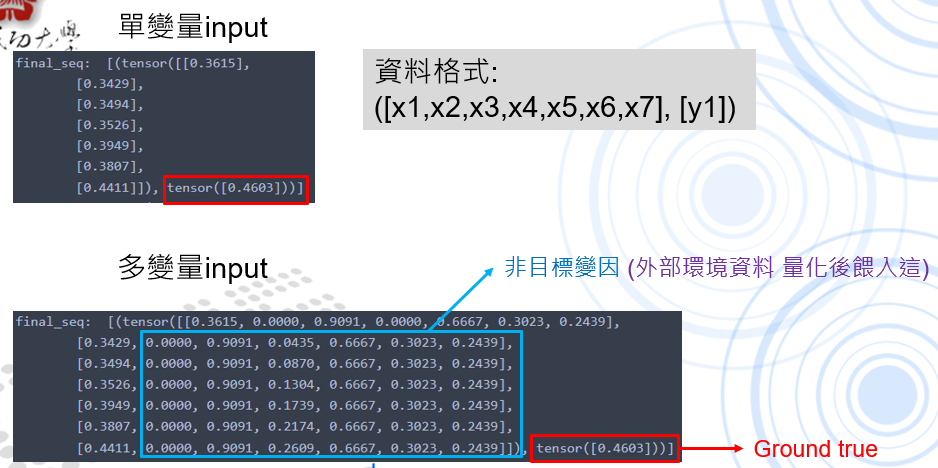

In [9]:
def multi_days_seq_data(args, seq_len, target, other, pred_day, jump_day):  # 將資料轉成序列形式，符合model之輸入格式
    final_seq = []  # 最終list，一列一回seq_len
    """
    轉成符合seq_len之"時序data"
      data_seq: x(target),q,w,e,r(其他變量)
      data_label: y (Ground True) 
      final_seq: 第一組:[[x,q,w,e,r],[x,q,w,e,r],[y]] ...
    --------------------------------------------------------
    pred_day: 一次預測的天數
    jump_day: 每筆資料要跳躍的天數。 訓練時->不跳躍(=1)； 測試時->跳躍(=pred_day)
    k: 看有幾個變量，調整range(根據dataset而變)
    """
    
    for i in range(0, len(other) - seq_len - (pred_day-1), jump_day):  # 進入下一回seq_len (len範圍:所有資料之列數 = len(dataset))
        data_seq = []
        data_label = []
        for j in range(i, i + seq_len):  # 當回seq_len填入
            x = [target[j]]
            # ++++++++++++++
            # intput -> 添加多變量
            for k in range(2, args.input_size+1): # 放入其餘副變量 (跳過日期&主變量)
                x.append(other[j][k])  # 列/行
            # +++++++++++++
            data_seq.append(x)
            
        # +++++++++++++
        # output -> 添加多天ground true
        for j in range(i + seq_len, i + seq_len + pred_day):
            data_label.append(target[j])
        # +++++++++++++
        #data_label.append(target[i + seq_len])

        data_seq = torch.FloatTensor(data_seq)  # 轉成tensor + float
        data_label = torch.FloatTensor(data_label)  # 轉成tensor + float
        #-print("data_seq:\n", data_seq)
        #-print("\ndata_label:\n", data_label)
        #-print("data_seq: ",data_seq)
        final_seq.append((data_seq, data_label))
        #-print("final_seq: ",final_seq)
        #-print("\nfinal_seq:",final_seq,"\n長度:",len(final_seq))
        #-print("-------------------\n\n\n")
    print(f'seq_len: {seq_len}')
    print(f'總列數: ({len(other)}, {len(other[0])})')
    print(f'序列化_seq_data: ({len(final_seq)}, {len(final_seq[0])})\n')
    
    (a,b) = final_seq[0]
    print("示範:")
    print("seq:", a)
    print("label:", b,"\n----------------------------\n")
    
    return final_seq

## 批次化

In [10]:
def batch_data(final_seq, batch_size):  # 若dataset過大，使用批次訓練，跑完dataset之回合數=(len(dataset)/batch_size)
    final_seq = DataLoader(dataset=final_seq, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)
    return final_seq

# 數據前處理 (Main)

## 單變量_前處理

In [11]:
# 單變量單步長(Univariate-SingleStep-LSTM) data processing
def Univar_SingleStep_seq(seq_len, batch_size):
    # 讀取原始資料
    dataset = load_dataset()  # ~load_data()
    # 切割訓練資料
    train, val, test = split_data(dataset)  # ~split_data()
    
    # 特徵縮放(Feature Scaling)
    target, other, m, n = normalize_data(train, train)  # ~normalize_data()
    # 根據seq_len序列化資料
    final_seq = seq_data(seq_len, target, other)  # ~seq_data
    # 批次化資料
    Train_seq = batch_data(final_seq, batch_size)  # train_data (~batch_data)
    
    # val, test做一樣事情
    target, other,_,_ = normalize_data(val, train)
    final_seq = seq_data(seq_len, target, other)
    Val_seq = batch_data(final_seq, batch_size)  # val_data
    target, other,_,_ = normalize_data(test, train)
    final_seq = seq_data(seq_len, target, other)
    Test_seq = batch_data(final_seq, batch_size)  # test_data

    return Train_seq, Val_seq, Test_seq, m, n # shape=(len(dataset), 2)

# 單獨測試
#Univar_SingleStep_seq(7,30) # seq_len=7, batch_size=30

## 多變量序列

In [12]:
# 多變量單步長(Multivariate-SingleStep-LSTM) data processing
def Multivariate_SingleStep_seq(seq_len, batch_size):
    # 傳入args參數
    args = Multivariate_SingleStep_args() 
    # 讀取原始資料
    dataset = load_dataset()  # ~load_data()
    # 切割訓練資料
    train, val, test = split_data(dataset)  # ~split_data()
    
    # 特徵縮放(Feature Scaling)
    target, other, m, n = normalize_data(train, train)  # ~normalize_data()
    # 根據seq_len序列化資料
    # ++++++++++++++
    final_seq = multi_seq_data(args, seq_len, target, other)  # ~multi_seq_data
    # ++++++++++++++
    # 批次化資料
    Train_seq = batch_data(final_seq, batch_size)  # train_data (~batch_data)
    
    # val, test做一樣事情
    target, other,_,_ = normalize_data(val, train)
    final_seq = multi_seq_data(args, seq_len, target, other)
    Val_seq = batch_data(final_seq, batch_size)  # val_data
    target, other,_,_ = normalize_data(test, train)
    final_seq = multi_seq_data(args, seq_len, target, other)
    Test_seq = batch_data(final_seq, batch_size)  # test_data

    return Train_seq, Val_seq, Test_seq, m, n # shape=(len(dataset), 2)

## 多變量+多天預測序列

In [13]:
# 多變量單步長(Multivariate-SingleStep-LSTM) data processing
def Multivariate_MultiStep_seq(seq_len, batch_size, pred_day, jump_day):
    # 傳入args參數
    args = Multivariate_MultiStep_args()
    # 讀取原始資料
    dataset = load_dataset()  # ~load_data()
    # 切割訓練資料
    train, val, test = split_data(dataset)  # ~split_data()
    
    # 特徵縮放(Feature Scaling)
    target, other, m, n = normalize_data(train, train)  # ~normalize_data()
    # 根據seq_len序列化資料
    # ++++++++++++++
    final_seq = multi_days_seq_data(args, seq_len, target, other, pred_day, 1)  # 訓練時不需跳著訓練 ~multi_days_seq_data 
    # ++++++++++++++
    # 批次化資料
    Train_seq = batch_data(final_seq, batch_size)  # train_data (~batch_data)
    
    # val, test做一樣事情
    target, other,_,_ = normalize_data(val, train)
    final_seq = multi_days_seq_data(args, seq_len, target, other, pred_day, 1)
    Val_seq = batch_data(final_seq, batch_size)  # val_data
    target, other,_,_ = normalize_data(test, train)
    final_seq = multi_days_seq_data(args, seq_len, target, other, pred_day, jump_day)  # 測試時需要跳著，才不會重複預測天數
    Test_seq = batch_data(final_seq, batch_size)  # test_data

    return Train_seq, Val_seq, Test_seq, m, n # shape=(len(dataset), 2)